In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
!pwd
os.chdir('gdrive/My Drive/Graph_based_methods/HBcompare/')
!pwd

Mounted at /content/gdrive
/content
/content/gdrive/My Drive/Graph_based_methods/HBcompare


### Util.py

In [ ]:
import networkx as nx
import numpy as np
import random
import scipy.sparse as sp
from sklearn.model_selection import StratifiedKFold
from scipy.sparse import isspmatrix

"""Adapted from https://github.com/weihua916/powerful-gnns/blob/master/util.py"""

class S2VGraph(object):
    def __init__(self, g, label, node_tags=None, node_features=None):
        '''
            g: a networkx graph
            label: an integer graph label
            node_tags: a list of integer node tags
            node_features: a torch float tensor, one-hot representation of the tag that is used as input to neural nets
            edge_mat: a torch long tensor, contain edge list, will be used to create torch sparse tensor
            neighbors: list of neighbors (without self-loop)
        '''
        self.label = label
        self.g = g
        self.node_tags = node_tags
        self.neighbors = []
        self.node_features = 0
        self.edge_mat = 0
        self.max_neighbor = 0


def load_data(dataset, degree_as_tag):
    '''
        dataset: name of dataset
        test_proportion: ratio of test train split
        seed: random seed for random splitting of dataset
    '''

    print('loading data')
    g_list = []
    label_dict = {}
    feat_dict = {}

    with open('/content/gdrive/My Drive/Graph_based_methods/Graph_Transformer/dataset/%s/%s.txt' % (dataset, dataset), 'r') as f:
        n_g = int(f.readline().strip())
        for i in range(n_g):
            row = f.readline().strip().split()
            n, l = [int(w) for w in row]
            if not l in label_dict:
                mapped = len(label_dict)
                label_dict[l] = mapped
            g = nx.Graph()
            node_tags = []
            node_features = []
            n_edges = 0
            for j in range(n):
                g.add_node(j)
                row = f.readline().strip().split()
                tmp = int(row[1]) + 2
                if tmp == len(row):
                    # no node attributes
                    row = [int(w) for w in row]
                    attr = None
                else:
                    row, attr = [int(w) for w in row[:tmp]], np.array([float(w) for w in row[tmp:]])
                if not row[0] in feat_dict:
                    mapped = len(feat_dict)
                    feat_dict[row[0]] = mapped
                node_tags.append(feat_dict[row[0]])

                if tmp > len(row):
                    node_features.append(attr)

                n_edges += row[1]
                for k in range(2, len(row)):
                    g.add_edge(j, row[k])

            if node_features != []:
                node_features = np.stack(node_features)
                node_feature_flag = True
            else:
                node_features = None
                node_feature_flag = False

            assert len(g) == n

            g_list.append(S2VGraph(g, l, node_tags))
     

    #add labels and edge_mat       
    for g in g_list:
        g.neighbors = [[] for i in range(len(g.g))]
        for i, j in g.g.edges():
            g.neighbors[i].append(j)
            g.neighbors[j].append(i)
        degree_list = []
        for i in range(len(g.g)):
            g.neighbors[i] = g.neighbors[i]
            degree_list.append(len(g.neighbors[i]))
        g.max_neighbor = max(degree_list)

        g.label = label_dict[g.label]

        edges = [list(pair) for pair in g.g.edges()]
        edges.extend([[i, j] for j, i in edges])

        deg_list = list(dict(g.g.degree(range(len(g.g)))).values())

        g.edge_mat = np.transpose(np.array(edges, dtype=np.int32), (1,0))

    if degree_as_tag:
        for g in g_list:
            g.node_tags = list(dict(g.g.degree).values())

    #Extracting unique tag labels   
    tagset = set([])
    for g in g_list:
        tagset = tagset.union(set(g.node_tags))

    tagset = list(tagset)
    tag2index = {tagset[i]:i for i in range(len(tagset))}

    for g in g_list:
        g.node_features = np.zeros((len(g.node_tags), len(tagset)), dtype=np.float32)
        g.node_features[range(len(g.node_tags)), [tag2index[tag] for tag in g.node_tags]] = 1


    print('# classes: %d' % len(label_dict))
    print('# maximum node tag: %d' % len(tagset))

    print("# data: %d" % len(g_list))

    return g_list, len(label_dict)


def separate_data(graph_list, fold_idx, seed=0):
    assert 0 <= fold_idx and fold_idx < 10, "fold_idx must be from 0 to 9."
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

    labels = [graph.label for graph in graph_list]
    idx_list = []
    for idx in skf.split(np.zeros(len(labels)), labels):
        idx_list.append(idx)
    train_idx, test_idx = idx_list[fold_idx]

    train_graph_list = [graph_list[i] for i in train_idx]
    test_graph_list = [graph_list[i] for i in test_idx]

    return train_graph_list, test_graph_list
    

"""Get indexes of train and test sets"""
def separate_data_idx(graph_list, fold_idx, seed=0):
    assert 0 <= fold_idx and fold_idx < 10, "fold_idx must be from 0 to 9."
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    labels = [graph.label for graph in graph_list]
    idx_list = []
    for idx in skf.split(np.zeros(len(labels)), labels):
        idx_list.append(idx)
    train_idx, test_idx = idx_list[fold_idx]

    return train_idx, test_idx

"""Convert sparse matrix to tuple representation."""
def sparse_to_tuple(sparse_mx):
    def to_tuple(mx):
        if not sp.isspmatrix_coo(mx):
            mx = mx.tocoo()
        coords = np.vstack((mx.row, mx.col)).transpose()
        values = mx.data
        shape = mx.shape
        return coords, values, shape

    if isinstance(sparse_mx, list):
        for i in range(len(sparse_mx)):
            sparse_mx[i] = to_tuple(sparse_mx[i])
    else:
        sparse_mx = to_tuple(sparse_mx)

    return sparse_mx


data_name = "dataset5"
use_degree_as_tag = True

graphs, num_classes = load_data(data_name, use_degree_as_tag)

loading data
# classes: 2
# maximum node tag: 26
# data: 47


### GCN_layer.py

In [ ]:
# %tensorflow_version 1.x
!pip install tensorflow==1.15.0
import tensorflow as tf
print(tf.__version__)
import numpy as np

'''
    Thomas N. Kipf, Max Welling. 2017. Semi-Supervised Classification with Graph Convolutional Networks. ICLR.
    Modified from https://github.com/tkipf/gcn/blob/master/gcn/layers.py
'''

def uniform(shape, scale=0.05, name=None):
    """Uniform init."""
    initial = tf.random_uniform(shape, minval=-scale, maxval=scale, dtype=tf.float32)
    return tf.Variable(initial, name=name)

def glorot(shape, name=None):
    """Glorot & Bengio (AISTATS 2010) init."""
    init_range = np.sqrt(6.0 / (shape[0] + shape[1]))
    initial = tf.compat.v1.random_uniform(shape, minval=-init_range, maxval=init_range, dtype=tf.float32)
    return tf.Variable(initial, name=name)

def zeros(shape, name=None):
    """All zeros."""
    initial = tf.zeros(shape, dtype=tf.float32)
    return tf.Variable(initial, name=name)

def ones(shape, name=None):
    """All ones."""
    initial = tf.ones(shape, dtype=tf.float32)
    return tf.Variable(initial, name=name)

flags = tf.compat.v1.flags
FLAGS = flags.FLAGS

# global unique layer ID dictionary for layer name assignment
_LAYER_UIDS = {}

def get_layer_uid(layer_name=''):
    """Helper function, assigns unique layer IDs."""
    if layer_name not in _LAYER_UIDS:
        _LAYER_UIDS[layer_name] = 1
        return 1
    else:
        _LAYER_UIDS[layer_name] += 1
        return _LAYER_UIDS[layer_name]

def sparse_dropout(x, keep_prob, noise_shape):
    """Dropout for sparse tensors."""
    random_tensor = keep_prob
    random_tensor += tf.compat.v1.random_uniform(noise_shape)
    dropout_mask = tf.cast(tf.floor(random_tensor), dtype=tf.bool)
    pre_out = tf.compat.v1.sparse_retain(x, dropout_mask)
    return pre_out * (1./keep_prob)

def dot(x, y, sparse=False):
    """Wrapper for tf.matmul (sparse vs dense)."""
    if sparse:
        res = tf.compat.v1.sparse_tensor_dense_matmul(x, y)
    else:
        res = tf.matmul(x, y)
    return res

class Layer(object):
    """Base layer class. Defines basic API for all layer objects.
    Implementation inspired by keras (http://keras.io).

    # Properties
        name: String, defines the variable scope of the layer.
        logging: Boolean, switches Tensorflow histogram logging on/off

    # Methods
        _call(inputs): Defines computation graph of layer
            (i.e. takes input, returns output)
        __call__(inputs): Wrapper for _call()
        _log_vars(): Log all variables
    """

    def __init__(self, **kwargs):
        allowed_kwargs = {'name', 'logging'}
        for kwarg in kwargs.keys():
            assert kwarg in allowed_kwargs, 'Invalid keyword argument: ' + kwarg
        name = kwargs.get('name')
        if not name:
            layer = self.__class__.__name__.lower()
            name = layer + '_' + str(get_layer_uid(layer))
        self.name = name
        self.vars = {}
        logging = kwargs.get('logging', False)
        self.logging = logging
        self.sparse_inputs = False

    def _call(self, inputs):
        return inputs

    def __call__(self, inputs):
        with tf.name_scope(self.name):
            if self.logging and not self.sparse_inputs:
                tf.compat.v1.summary.histogram(self.name + '/inputs', inputs)
            outputs = self._call(inputs)
            if self.logging:
                tf.compat.v1.summary.histogram(self.name + '/outputs', outputs)
            return outputs

    def _log_vars(self):
        for var in self.vars:
            tf.compat.v1.summary.histogram(self.name + '/vars/' + var, self.vars[var])


class GraphConvolution(Layer):
    """Graph convolution layer."""
    def __init__(self, input_dim, output_dim, placeholders, dropout=0.,
                 sparse_inputs=False, act=tf.nn.relu, bias=False,
                 featureless=False, **kwargs):
        super(GraphConvolution, self).__init__(**kwargs)

        if dropout:
            self.dropout = placeholders['dropout']
        else:
            self.dropout = 0.

        self.act = act
        self.adj = placeholders['adj']
        self.sparse_inputs = sparse_inputs
        self.featureless = featureless
        self.bias = bias

        # helper variable for sparse dropout
        self.num_features_nonzero = placeholders['num_features_nonzero']

        with tf.compat.v1.variable_scope(self.name + '_vars'):
            self.vars['weights'] = glorot([input_dim, output_dim], name='weights')
            if self.bias:
                self.vars['bias'] = zeros([output_dim], name='bias')

        if self.logging:
            self._log_vars()

    def _call(self, inputs):
        x = inputs

        # dropout
        if self.sparse_inputs:
            x = sparse_dropout(x, 1-self.dropout, self.num_features_nonzero)
        else:
            x = tf.nn.dropout(x, 1-self.dropout)

        # convolve
        if not self.featureless:
            pre_sup = dot(x, self.vars['weights'], sparse=self.sparse_inputs)
        else:
            pre_sup = self.vars['weights']
        output = dot(self.adj, pre_sup, sparse=True)

        # bias
        if self.bias:
            output += self.vars['bias']

        return self.act(output)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 412.3 MB 24 kB/s 
     |████████████████████████████████| 50 kB 8.3 MB/s 
     |████████████████████████████████| 3.8 MB 47.2 MB/s 
     |████████████████████████████████| 503 kB 69.1 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=bd7b5fad653c12ae3b071f8534069ed9c5ddff2d0fe97158ff224078463e9e4b
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting un

### Model_unsup_gcn.py

In [ ]:
class GCN_graph_cls(object):
    def __init__(self, feature_dim_size, hidden_size, num_GNN_layers, num_sampled, vocab_size):
        # Placeholders for input, output
        self.Adj_block = tf.compat.v1.sparse_placeholder(tf.float32, [None, None], name="Adj_block")
        self.X_concat = tf.compat.v1.sparse_placeholder(tf.float32, [None, feature_dim_size], name="X_concat")
        self.num_features_nonzero = tf.compat.v1.placeholder(tf.int32, name="num_features_nonzero")
        self.dropout = tf.compat.v1.placeholder(tf.float32, name="dropout")
        self.input_y = tf.compat.v1.placeholder(tf.int32, [None, 1], name="input_y")

        self.placeholders = {
            'adj': self.Adj_block,
            'dropout': self.dropout,
            'num_features_nonzero': self.num_features_nonzero
        }

        self.input = self.X_concat   # set hidden_size = feature_dim_size if not tuning sizes of hidden stacked layers
        in_hidden_size = feature_dim_size
        print('in_hidden_size = ', in_hidden_size)
        self.output_vectors = []
        #Construct k GNN layers
        for idx_layer in range(num_GNN_layers):
            sparse_inputs = False
            if idx_layer == 0:
                sparse_inputs = True
            gcn_gnn = GraphConvolution(input_dim=in_hidden_size,
                                                  output_dim=hidden_size,
                                                  placeholders=self.placeholders,
                                                  act=tf.nn.relu,
                                                  dropout=True,
                                                  sparse_inputs=sparse_inputs)

            in_hidden_size = hidden_size
            
            # print('in_hidden_size2 = ', in_hidden_size)
            # run --> output --> input for next layer
            self.input = gcn_gnn(self.input)

            # print('shape = ', self.input.get_shape)
            #
            self.output_vectors.append(self.input)

        self.output_vectors = tf.concat(self.output_vectors, axis=1)
        self.output_vectors = tf.nn.dropout(self.output_vectors, 1-self.dropout)

        with tf.name_scope("embedding"):
            self.embedding_matrix = glorot([vocab_size, hidden_size*num_GNN_layers], name='node_embeddings')
            self.softmax_biases = tf.Variable(tf.zeros([vocab_size]))

        self.total_loss = tf.reduce_mean(
            tf.nn.sampled_softmax_loss(weights=self.embedding_matrix, biases=self.softmax_biases,
                                       inputs=self.output_vectors, labels=self.input_y, num_sampled=num_sampled, num_classes=vocab_size))

        self.saver = tf.compat.v1.train.Saver(tf.global_variables(), max_to_keep=500)
        tf.logging.info('Seting up the main structure')

### Calculate Metrics

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn import preprocessing

def cal_acc_only(predicted, gt):
  correct = 0
  for i in range(len(predicted)):
    if(predicted[i] == gt[i]):
      correct += 1

  acc = correct/len(predicted)

  return acc

def calculate_acc(predicted, gt):
  correct = 0
  for i in range(len(predicted)):
    if(predicted[i] == gt[i]):
      correct += 1

  acc = correct/len(predicted)

  lb = preprocessing.LabelBinarizer()
  lb.fit(gt)

  gt_binary = lb.transform(gt)
  predicted_binary = lb.transform(predicted)

  auc = roc_auc_score(gt_binary, predicted_binary, average = 'macro')
  precision, recall, f1score, support = precision_recall_fscore_support(gt_binary, predicted_binary, average = 'macro')

  A = classification_report(predicted, gt, digits = 4)
  print(A)


  return acc, auc, precision, recall, f1score

### Parameters

In [ ]:
# Parameters
# ==================================================

parser = ArgumentParser("GCN_Unsup", formatter_class=ArgumentDefaultsHelpFormatter, conflict_handler='resolve')

parser.add_argument("--run_folder", default="../", help="")
parser.add_argument("--dataset", default="dataset5", help="Name of the dataset.")
parser.add_argument("--learning_rate", default=0.001, type=float, help="Learning rate")
parser.add_argument("--batch_size", default = 4, type=int, help="Batch Size")
parser.add_argument("--num_epochs", default = 50, type=int, help="Number of training epochs")
parser.add_argument("--saveStep", default=1, type=int, help="")
parser.add_argument("--allow_soft_placement", default=True, type=bool, help="Allow device soft device placement")
parser.add_argument("--log_device_placement", default=False, type=bool, help="Log placement of ops on devices")
parser.add_argument("--model_name", default='MUTAG', help="")
parser.add_argument("--dropout", default=0.5, type=float, help="Dropout")
parser.add_argument("--num_GNN_layers", default=6, type=int, help="Number of stacked layers")
parser.add_argument("--hidden_size", default=64, type=int, help="size of hidden layers")
parser.add_argument('--num_sampled', default=512, type=int, help='')
# args = parser.parse_args()
args = parser.parse_args(args = [])

print(args)

# Load data
print("Loading data...")

use_degree_as_tag = False

if args.dataset == 'COLLAB' or args.dataset == 'IMDBBINARY' or args.dataset == 'IMDBMULTI':
    use_degree_as_tag = True
graphs, num_classes = load_data(args.dataset, use_degree_as_tag)
feature_dim_size = graphs[0].node_features.shape[1]
graph_labels = np.array([graph.label for graph in graphs])
if "REDDIT" in args.dataset:
    feature_dim_size = 4

### Train HBcompare

In [ ]:
#! /usr/bin/env python
!pip install keras
!pip install keract

import tensorflow as tf
import numpy as np
np.random.seed(123)
tf.compat.v1.set_random_seed(123)

import os
import time
import datetime
import pickle as cPickle
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter
from scipy.sparse import coo_matrix
import statistics
from sklearn.linear_model import LogisticRegression

from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from tensorflow.keras import backend as K
from keract import get_activations
import keract

def FCN_classify(X_train, X_test, label_train, label_test, num_classes):
  model = models.Sequential()
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(num_classes, activation='softmax'))
  model.summary()

  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  
  model.fit(X_train, label_train, epochs = 166, verbose =0)

  predictions = model.predict(X_test)

  predicted_labales = np.argmax(predictions, axis = 1)

  # print(' acc ', acc, ' auc ', auc) 
  return predicted_labales

  

def get_Adj_matrix(batch_graph):
    edge_mat_list = []
    start_idx = [0]
    for i, graph in enumerate(batch_graph):
        start_idx.append(start_idx[i] + len(graph.g))
        edge_mat_list.append(graph.edge_mat + start_idx[i])

    Adj_block_idx = np.concatenate(edge_mat_list, 1)
    Adj_block_elem = np.ones(Adj_block_idx.shape[1])

    #self-loop
    num_node = start_idx[-1]
    self_loop_edge = np.array([range(num_node), range(num_node)])
    elem = np.ones(num_node)
    Adj_block_idx = np.concatenate([Adj_block_idx, self_loop_edge], 1)
    Adj_block_elem = np.concatenate([Adj_block_elem, elem], 0)

    Adj_block = coo_matrix((Adj_block_elem, Adj_block_idx), shape=(num_node, num_node))

    return Adj_block

def get_graphpool(batch_graph):
    start_idx = [0]
    # compute the padded neighbor list
    for i, graph in enumerate(batch_graph):
        start_idx.append(start_idx[i] + len(graph.g))

    idx = []
    elem = []
    for i, graph in enumerate(batch_graph):
        elem.extend([1] * len(graph.g))
        idx.extend([[i, j] for j in range(start_idx[i], start_idx[i + 1], 1)])

    elem = np.array(elem)
    idx = np.array(idx)

    graph_pool = coo_matrix((elem, (idx[:, 0], idx[:, 1])), shape=(len(batch_graph), start_idx[-1]))
    return graph_pool

graph_pool = get_graphpool(graphs)

def get_idx_nodes(selected_graph_idx):
    idx_nodes = [np.where(graph_pool.getrow(i).toarray()[0] == 1)[0] for i in selected_graph_idx]
    idx_nodes = np.reshape(np.concatenate(idx_nodes), (-1, 1))
    return idx_nodes

def get_batch_data(batch_graph):
    # features
    X_concat = np.concatenate([graph.node_features for graph in batch_graph], 0)
    if "REDDIT" in args.dataset:
        X_concat = np.tile(X_concat, feature_dim_size) #[1,1,1,1]
        X_concat = X_concat * 0.01

    X_concat = coo_matrix(X_concat)
    X_concat = sparse_to_tuple(X_concat)
    # adj
    Adj_block = get_Adj_matrix(batch_graph)
    Adj_block = sparse_to_tuple(Adj_block)

    num_features_nonzero = X_concat[1].shape
    return Adj_block, X_concat, num_features_nonzero

class Batch_Loader(object):
    def __call__(self):
        selected_idx = np.random.permutation(len(graphs))[:args.batch_size]
        batch_graph = [graphs[idx] for idx in selected_idx]
        Adj_block, X_concat, num_features_nonzero = get_batch_data(batch_graph)
        idx_nodes = get_idx_nodes(selected_idx)
        return Adj_block, X_concat, num_features_nonzero, idx_nodes

batch_nodes = Batch_Loader()

print("Loading data... finished!")
# Training
# ==================================================
def run_HBCompare_training():
  with tf.Graph().as_default():
      session_conf = tf.compat.v1.ConfigProto(allow_soft_placement=args.allow_soft_placement, log_device_placement=args.log_device_placement)
      session_conf.gpu_options.allow_growth = True
      sess = tf.compat.v1.Session(config=session_conf)
      with sess.as_default():
          global_step = tf.Variable(0, name="global_step", trainable=False)
          print("Feature_dim_size = ", feature_dim_size)
          print("Hidden_size = ", args.hidden_size)
          print("Graph_pool_shape = ", graph_pool.shape[0], " ... ", graph_pool.shape[1])
          print("num_sampled = ", args.num_sampled)

          unsup_gcn = GCN_graph_cls(feature_dim_size=feature_dim_size,
                        hidden_size=args.hidden_size,
                        num_GNN_layers=args.num_GNN_layers,
                        vocab_size=graph_pool.shape[1],
                        num_sampled=args.num_sampled,
                        )

          # Define Training procedure
          optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=args.learning_rate)
          grads_and_vars = optimizer.compute_gradients(unsup_gcn.total_loss)
          train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

          out_dir = os.path.abspath(os.path.join(args.run_folder, "../runs_GCN_UnSup", args.model_name))
          print("Writing to {}\n".format(out_dir))

          # Checkpoint directory. Tensorflow assumes this directory already exists so we need to create it
          checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
          checkpoint_prefix = os.path.join(checkpoint_dir, "model")
          if not os.path.exists(checkpoint_dir):
              os.makedirs(checkpoint_dir)

          # Initialize all variables
          sess.run(tf.compat.v1.global_variables_initializer())
          graph = tf.compat.v1.get_default_graph()

          def train_step(Adj_block, X_concat, num_features_nonzero, idx_nodes):
              feed_dict = {
                  unsup_gcn.Adj_block: Adj_block,
                  unsup_gcn.X_concat: X_concat,
                  unsup_gcn.num_features_nonzero: num_features_nonzero,
                  unsup_gcn.dropout: args.dropout,
                  unsup_gcn.input_y:idx_nodes
              }
              _, step, loss = sess.run([train_op, global_step, unsup_gcn.total_loss], feed_dict)
              return loss

          # write_acc = open(checkpoint_prefix + '_acc.txt', 'w')
          max_acc = 0.0
          idx_epoch = 0
          num_batches_per_epoch = int((len(graphs) - 1) / args.batch_size) + 1
          predicted_labels = []
          acc_all = []
          auc_all = []
          f1score_all = []
          acc_test_all = []

          mean_each_epoch = []
          std_each_epoch = []
          time_each_epoch = []

          start_time = time.time()

          for epoch in range(1, args.num_epochs+1):
              loss = 0
              # print("Num_features_nonzero at ", epoch, " = ", num_features_nonzero)
              for _ in range(num_batches_per_epoch):
                  Adj_block, X_concat, num_features_nonzero, idx_nodes = batch_nodes()
                  loss += train_step(Adj_block, X_concat, num_features_nonzero, idx_nodes)
                  # current_step = tf.compat.v1.train.global_step(sess, global_step)
              print(loss)
              # It will give tensor object
              node_embeddings = graph.get_tensor_by_name('embedding/node_embeddings:0')
              node_embeddings = sess.run(node_embeddings)
              graph_embeddings = graph_pool.dot(node_embeddings)
              #
              acc_10folds = []
              for fold_idx in range(0,5):
                  train_idx, test_idx = separate_data_idx(graphs, fold_idx)
                  train_graph_embeddings = graph_embeddings[train_idx]
                  test_graph_embeddings = graph_embeddings[test_idx]
                  train_labels = graph_labels[train_idx]
                  test_labels = graph_labels[test_idx]

                  cls = LogisticRegression(tol=0.001, max_iter = 2000)
                  cls.fit(train_graph_embeddings, train_labels)
                  # ACC_test = cls.score(test_graph_embeddings, test_labels)
                  predicted = cls.predict(test_graph_embeddings)
                  ACC = cal_acc_only(predicted, test_labels)


                  if(epoch == args.num_epochs):
                    predicted = cls.predict(test_graph_embeddings)
                    predicted_labels.append(predicted)

                    acc, auc, precision, recall, f1score = calculate_acc(predicted, test_labels)
                    acc_all.append(acc)
                    auc_all.append(auc)
                    f1score_all.append(f1score)

                  acc_10folds.append(ACC)
                  print('epoch ', epoch, ' fold ', fold_idx, ' acc ', ACC)

              mean_10folds = statistics.mean(acc_10folds)
              std_10folds = statistics.stdev(acc_10folds)
              print('epoch ', epoch, ' mean: ', str(mean_10folds*100), ' std: ', str(std_10folds*100))

              ACC_test = cls.score(test_graph_embeddings, test_labels)
              acc_test_all.append(ACC_test)

              mean_each_epoch.append(str(mean_10folds*100))
              std_each_epoch.append(str(std_10folds*100))
              time_each_epoch.append(time.time()-start_time)

  end_time = time.time()
  total_time = end_time - start_time
  print("--- %s seconds ---" % total_time)

  print('acc_all', acc_all)   

  print('auc_all', auc_all)  

  return acc_all, auc_all, f1score_all, mean_each_epoch, std_each_epoch, time_each_epoch, total_time

all_acc = []
all_auc = []
all_f1score = []
all_mean_each_epoch = []
all_std_each_epoch = []
all_time_each_epoch = []
all_time = []
iter = 10
for i in range(iter):
  acc_all,auc_all, f1score_all, mean_each_epoch, std_each_epoch, time_each_epoch, total_time= run_HBCompare_training()
  all_acc.append(acc_all)
  all_auc.append(auc_all)
  all_f1score.append(f1score_all)
  all_mean_each_epoch.append(mean_each_epoch)
  all_std_each_epoch.append(std_each_epoch)
  all_time_each_epoch.append(time_each_epoch)
  all_time.append(total_time)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Namespace(allow_soft_placement=True, batch_size=4, dataset='dataset5', dropout=0.5, hidden_size=64, learning_rate=0.001, log_device_placement=False, model_name='MUTAG', num_GNN_layers=6, num_epochs=50, num_sampled=512, run_folder='../', saveStep=1)
Loading data...
loading data
# classes: 2
# maximum node tag: 3
# data: 47
Loading data... finished!
Feature_dim_size =  3
Hidden_size =  64
Graph_pool_shape =  47  ...  42321
num_sampled =  512
in_hidden_size =  3
Writing to /content/gdrive/My Drive/runs_GCN_UnSup/MUTAG

3846.055377483368
epoch  1  fold  0  acc  0.7
epoch  1  fold  1  acc  0.7
epoch  1  fold  2  acc  0.8888888888888888
epoch  1  fold  3  acc  0.4444444444444444
epoch  1  fold  4  acc  1.0
epoch  1  mean:  74.66666666666666  std:  21.21902244638633
62.28598976135254
epoch  2  fold

In [ ]:
print(all_acc)

def print_results(all_acc, all_auc, all_f1score, all_time):
  print("Accuracy from all runs: ", all_acc)
  print("AUC from all runs: ",all_auc)
  total = 0
  count = 0
  for i in range(len(all_acc)):
    for each in all_acc[i]:
      total += each
      count += 1
  print("Average acc = ", total/count)

  total = 0
  count = 0
  for i in range(len(all_auc)):
    for each in all_auc[i]:
      total += each
      count += 1
  print("Average auc = ", total/count)

  total = 0
  count = 0
  for i in range(len(all_f1score)):
    for each in all_f1score[i]:
      total += each
      count += 1
  print("Average f1score = ", total/count)

print("--- %s seconds ---" % (all_time))
print_results(all_acc, all_auc, all_f1score, all_time)


[[0.9, 0.9, 0.8888888888888888, 0.8888888888888888, 1.0], [1.0, 0.9, 0.8888888888888888, 0.7777777777777778, 1.0], [0.8, 1.0, 0.8888888888888888, 0.8888888888888888, 1.0], [0.9, 0.9, 0.8888888888888888, 0.8888888888888888, 1.0], [1.0, 0.9, 0.8888888888888888, 0.8888888888888888, 1.0], [1.0, 0.9, 0.8888888888888888, 0.8888888888888888, 1.0], [0.9, 0.8, 0.8888888888888888, 0.6666666666666666, 1.0], [1.0, 0.9, 1.0, 0.8888888888888888, 1.0], [1.0, 0.9, 0.8888888888888888, 1.0, 1.0], [0.8, 0.8, 1.0, 0.8888888888888888, 1.0]]
--- [41.889583349227905, 40.56093740463257, 41.17266607284546, 40.04051733016968, 36.63104176521301, 36.009239196777344, 43.17693281173706, 38.242395877838135, 37.98713421821594, 38.388838052749634] seconds ---
Accuracy from all runs:  [[0.9, 0.9, 0.8888888888888888, 0.8888888888888888, 1.0], [1.0, 0.9, 0.8888888888888888, 0.7777777777777778, 1.0], [0.8, 1.0, 0.8888888888888888, 0.8888888888888888, 1.0], [0.9, 0.9, 0.8888888888888888, 0.8888888888888888, 1.0], [1.0, 0.9

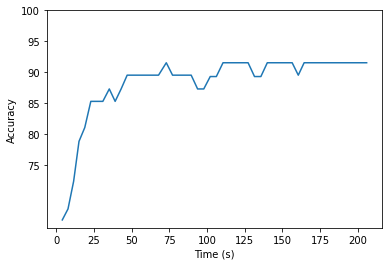

10


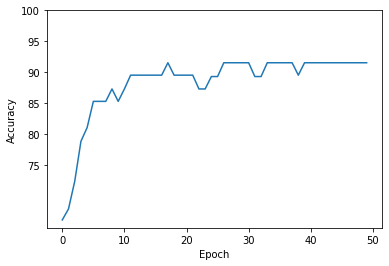

50


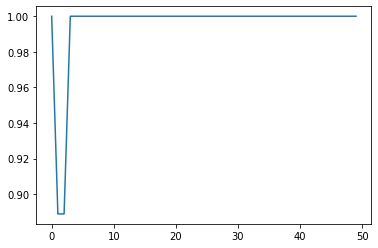

In [ ]:
plt.figure(0)
plt.plot(time_each_epoch, mean_each_epoch)
plt.xlabel("Time (s)")
plt.ylabel("Accuracy")
plt.yticks(np.arange(75,105,5))
plt.show()

print("10")

plt.figure(1)
plt.plot(range(0,50), mean_each_epoch)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.yticks(np.arange(75,105,5))
plt.show()

print(len(acc_test_all))
plt.figure(2)
plt.plot(range(0,50), acc_test_all)
plt.show()